In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, KFold


from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [2]:
df_full = pd.read_csv('../data/regression_lufu_2021-08-03.csv')

In [3]:
# Select variables
selected = [
    'id', 'gender', 'apgar_5min',
    'respiration_inv_days',
    'respiration_non_inv_days',
    'early_onset_infection', 'steroids', 'bpd_severity',
    'gest_age', 'birth_weight_g','body_size_cm',
    'volume', 'volume_ratio', 
]

df_regression=df_full[selected]

# Add variable of respiratory support (invasive + non-invasive)
resp_support_days = df_regression['respiration_inv_days'].to_numpy()+df_regression['respiration_non_inv_days'].to_numpy()
df_regression.insert(5, "resp_support_days", resp_support_days, True)

# Change gender to numerical 
gender_dict = {'f':0, 'm':1}
df_regression.replace({"gender": gender_dict}, inplace=True)

# Create volume variable but normalized by the birth weight
volume_per_kg= 1000*df_regression['volume'].to_numpy()/df_regression['birth_weight_g'].to_numpy()
df_regression.insert(13, "volume_per_kg", volume_per_kg, True)

# Create binary prediction variables
binary_no_vs_all = df_regression['bpd_severity'].apply(lambda x: 0 if x < 1 else 1)
df_regression.insert(15, "bpd_no_vs_all", binary_no_vs_all, True)


/Users/castelblanco/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


# Nested Cross Validation - Multinomial

In [4]:
def nested_cross_validation(X, y, depth_array, random_states, n_classes=4, n_splits_outer=5, n_splits_inner=5):

    grid_best_scores = []
    grid_best_p = []
    model_auc = []
    model_f1 = []
    model_weights = []
    outer_fold = []
    repetition_n = []
    
    # Compute ROC curve and ROC area for each class
    fpr_all = []
    tpr_all = []
    roc_auc_all = []

        
    for i in range(len(random_states)):
        random_state_i = random_states[i]
        p_grid = {
            "max_depth": depth_array,
                 }
        
        model_grid = RandomForestClassifier( 
            random_state=random_state_i
        )

        # OUTER FOLD
        outter_cv = StratifiedKFold(n_splits=n_splits_outer, shuffle=True, random_state=random_state_i).split(X, y)
        for j, (train, test) in enumerate(outter_cv):
            x_train = X.loc[train]
            y_train = y.loc[train]
            x_test = X.loc[test]
            y_test = y.loc[test]

            # Inner Fold => Find the best parameter
            inner_cv = KFold(n_splits=n_splits_inner, shuffle=True, random_state=random_state_i)
            grid = GridSearchCV(estimator=model_grid, param_grid=p_grid, cv=inner_cv)
            grid.fit(x_train,y_train)
            grid_best_scores.append(grid.best_score_)
            grid_best_p.append(grid.best_estimator_.max_depth)

            # Use the best parameter of the inner fold on the test
            model_rf = RandomForestClassifier(
                random_state=random_state_i, 
                max_depth=grid.best_estimator_.max_depth
            ).fit(x_train, y_train)

            # Perform Predictions
            y_predictions = model_rf.predict(x_test)
            y_predict_proba = model_rf.predict_proba(x_test)
            
            # one hot encoding y_test
            y_test_array = np.array(y_test)
            nb_classes = 4
            targets = y_test_array.reshape(-1)
            one_hot_y_test = np.eye(nb_classes)[targets]
            
            roc_auc = roc_auc_score(one_hot_y_test, y_predict_proba, average='weighted')
            f1_temp = f1_score(y_test, y_predictions, average='weighted')
            
            # Find FPR and TPR
            temp_fpr = dict()
            temp_tpr = dict()
            temp_roc_auc = dict()
            
            for i in range (n_classes):
                temp_fpr[i], temp_tpr[i], _ = roc_curve(one_hot_y_test[:, i], y_predict_proba[:, i])
                temp_roc_auc[i] = auc(temp_fpr[i], temp_tpr[i]) 
            

            model_auc.append(roc_auc)
            model_f1.append(f1_temp)
            model_weights.append(model_rf.feature_importances_)
            
            
            fpr_all.append(temp_fpr)
            tpr_all.append(temp_tpr)
            roc_auc_all.append(temp_roc_auc)
            
            
            outer_fold.append(j)
            repetition_n.append(i)

    df_results = pd.DataFrame.from_dict({
    'repetition_n':repetition_n,
    'outer_fold':outer_fold,
    'grid_best_inner_score': grid_best_scores,
    'grid_best_p': grid_best_p,
    'model_auc': model_auc,
    'model_f1': model_f1,
    'model_weights':model_weights,
    'fprs': fpr_all,
    'tprs': tpr_all,
    'roc_auc_all':roc_auc_all,
    })

    return df_results

In [5]:
def get_avg_auc_and_f1(df_in, print_out=True):   
    avg_by_repetition = df_in[['repetition_n','model_auc','model_f1']].groupby('repetition_n').mean()
    std_by_repetition = df_in[['repetition_n','model_auc','model_f1']].groupby('repetition_n').std()
    
    avg_auc = np.mean(avg_by_repetition['model_auc'].to_numpy())
    std_auc = np.mean(std_by_repetition['model_auc'].to_numpy())
    avg_f1 = np.mean(avg_by_repetition['model_f1'].to_numpy())
    std_f1 = np.mean(std_by_repetition['model_f1'].to_numpy())
    
    if print_out:
        print('auc',avg_auc, '+/-', std_auc)
        print('f1',avg_f1, '+/-', std_f1)
    return avg_auc, std_auc, avg_f1, std_f1


# Multinomial RF Classification

In [6]:
random_array = [641,752,710,639,782,873,700,84,679,246] 
tree_depth = [3,4,5,6,7,8,9,10,11,12,13,14,15]

### Only Volume Features

In [7]:
explanatory = [
    'volume_per_kg', 'volume_ratio', 
]

y_in=df_regression['bpd_severity']
X_in=df_regression[explanatory]

multi_only_volume = nested_cross_validation(X_in, y_in, depth_array=tree_depth, random_states=random_array)
avg_auc, std_auc, avg_f1, std_f1 = get_avg_auc_and_f1(multi_only_volume)


auc 0.7265046127144061 +/- 0.08491234724839322
f1 0.48965433719932866 +/- 0.10369742263945105


###  Volume + Patient

In [8]:
explanatory = [
    'gender', 'gest_age', 'birth_weight_g','body_size_cm',
    'volume_per_kg', 'volume_ratio', 
]

y_in=df_regression['bpd_severity']
X_in=df_regression[explanatory]

multi_volume_subject = nested_cross_validation(X_in, y_in, depth_array=tree_depth, random_states=random_array)
avg_auc, std_auc, avg_f1, std_f1 = get_avg_auc_and_f1(multi_volume_subject)


auc 0.768370179279539 +/- 0.07694188694041201
f1 0.5293468370480697 +/- 0.09491961492345906


###  Volume + Patient + Clinical

In [9]:
explanatory = [
    'gender', 'gest_age', 'birth_weight_g','body_size_cm',
    'apgar_5min','early_onset_infection', 'steroids',
    'volume_per_kg', 'volume_ratio', 
]

y_in=df_regression['bpd_severity']
X_in=df_regression[explanatory]

multi_volume_subject_clinical = nested_cross_validation(X_in, y_in, depth_array=tree_depth, random_states=random_array)
avg_auc, std_auc, avg_f1, std_f1 = get_avg_auc_and_f1(multi_volume_subject_clinical)



auc 0.7722427874996153 +/- 0.0692978356189938
f1 0.5387204692976034 +/- 0.08667646317311775


# Compare All

In [10]:
aucs = np.concatenate([
    multi_only_volume['model_auc'],
    multi_volume_subject['model_auc'],
    multi_volume_subject_clinical['model_auc'],
])

f1s = np.concatenate([
    multi_only_volume['model_f1'],
    multi_volume_subject['model_f1'],
    multi_volume_subject_clinical['model_f1'],]
)

selected_features = np.concatenate([
    np.repeat('V', len(multi_only_volume['model_auc'])),
    np.repeat('V + S', len(multi_volume_subject['model_auc'])),
    np.repeat('V + S + C', len(multi_volume_subject_clinical['model_auc'])),
]) 


df_plot_results = pd.DataFrame.from_dict({
    'auc':aucs,
    'f1':f1s,
    'Features': selected_features,
})

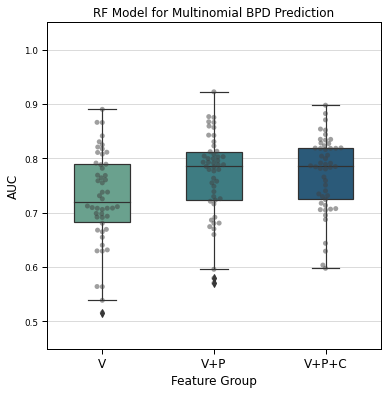

In [11]:
sns.set_context("paper")
font_s = 12


f = plt.figure(figsize=(6, 6))
gs = f.add_gridspec(1, 1)


ax = f.add_subplot(gs[0])
sns.boxplot(x='Features', y='auc',
            data=df_plot_results, 
            palette = 'crest',
            width = 0.5,
           )
sns.swarmplot(x='Features', y='auc',
              data=df_plot_results,
              color=".25",
              alpha=0.5
           )
ax.set_title('RF Model for Multinomial BPD Prediction', fontsize = font_s)
ax.set_ylabel('AUC', fontsize = font_s)
ax.set_xlabel('Feature Group', fontsize = font_s)
ax.set_ylim([0.450, 1.05])  

ax.set_xticklabels(['V','V+P','V+P+C'], fontsize = 12)

ax.set_axisbelow(True)
ax.yaxis.grid(color='lightgray')


#plt.savefig('MN_RF_AUC.pdf')
plt.show()

# ROC for RF Multiclass

Text(0, 0.5, 'True Positive Rate')

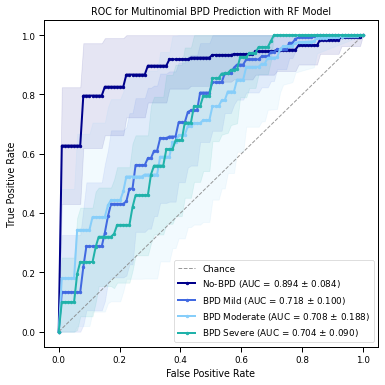

In [12]:
df_results = multi_volume_subject_clinical

n_classes = 4

colors = ['darkblue', 'royalblue', 'lightskyblue', 'lightseagreen']
labels = ['No-BPD', 'BPD Mild', 'BPD Moderate', 'BPD Severe']

tprs = df_results['tprs']
fprs = df_results['fprs']
aucs = df_results['roc_auc_all']


plot_mean_class_tpr = []
plot_tprs_lower = []
plot_tprs_upper = []
plot_mean_class_aucs = []
plot_std_class_aucs = []

#Interpolate tprs to find average for ROC 
mean_fpr = np.linspace(0, 1, 100)
for j in range(n_classes):
    tprs_class_interp=[]
    aucs_class=[]
    for i in range(len(tprs)):
        tpr_temp_class = tprs[i][j]
        fpr_temp_class = fprs[i][j]
        auc_temp_class = aucs[i][j]
        
        interp_tpr_temp = np.interp(mean_fpr, fpr_temp_class, tpr_temp_class)
        tprs_class_interp.append(interp_tpr_temp)
        aucs_class.append(auc_temp_class)
        
    mean_class_tpr = np.mean(tprs_class_interp, axis=0)
    mean_class_tpr[-1] = 1.0
    mean_class_tpr[0] = 0
    plot_mean_class_tpr.append(mean_class_tpr)
    
    std_tpr = np.std(tprs_class_interp, axis=0)
    tprs_upper = np.minimum(mean_class_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_class_tpr - std_tpr, 0)
    plot_tprs_upper.append(tprs_upper)
    plot_tprs_lower.append(tprs_lower)
    
    mean_class_auc = auc(mean_fpr, mean_class_tpr)
    std_class_auc = np.std(aucs_class)
    plot_mean_class_aucs.append(mean_class_auc)
    plot_std_class_aucs.append(std_class_auc)
    
    
    
# Figure
fig, ax = plt.subplots(figsize=(6, 6)) 
ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey', label='Chance', alpha=.8)
for i in range(n_classes):
    ax.fill_between(mean_fpr, plot_tprs_lower[i], plot_tprs_upper[i], 
                    color=colors[i], alpha=.1,
                    label='_nolegend_',)

for i in range(n_classes):    
    ax.plot(mean_fpr, plot_mean_class_tpr[i], marker='.',color=colors[i],
        label=labels[i]+r' (AUC = %0.3f $\pm$ %0.3f)' % (plot_mean_class_aucs[i], plot_std_class_aucs[i]),
        lw=2)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC for Multinomial BPD Prediction with RF Model")
ax.legend(loc="lower right")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")

#plt.savefig("roc_bpd_multinomial_RF.pdf")
